<a href="https://colab.research.google.com/github/ACTP2002/EVIDENCE/blob/behavior_model/Behavior_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
!pip install --no-cache-dir -U numpy scipy scikit-learn pandas

In [99]:
import numpy as np
import pandas as pd

from scipy.stats import median_abs_deviation

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

In [100]:
data_path = "synthetic_data_2026-02-07.csv"

df = pd.read_csv(data_path)
df.head()

,user_id,event_time,event_type,amount,currency,channel,declared_income,account_deposit,residence_country,transaction_country,amount_in_1d,amount_out_1d,login_count_1h,failed_login_1h,new_ip_1d,geo_change_1d
0,u_123,2025-04-29T00:41:35,deposit,4340.76,GBP,api,103233,201910,AU,AU,7383.39,7514.33,0,0,False,False
1,u_066,2025-12-12T02:40:46,withdrawal,7644.75,JPY,mobile,147944,491914,BR,BR,5619.80,13616.50,0,0,True,False
2,u_323,2025-03-03T11:31:43,sell,6430.32,USD,mobile,89130,57834,CN,CN,13932.37,3767.63,4,0,False,False
3,u_279,2025-11-24T00:26:14,buy,303.06,EUR,api,26802,421080,CN,CN,3947.08,1865.10,2,0,True,False
4,u_380,2025-04-22T23:01:29,buy,1164.22,EUR,api,25900,280156,MY,MY,1918.26,1456.34,0,0,False,False


In [101]:
# convert time to proper format
df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")
# sort by user id and event time
df = df.sort_values(["user_id", "event_time"]).reset_index(drop=True)

# Normalize categorical text to ensure all lower text
cat_cols_raw = [
    "currency", "channel",
    "residence_country", "transaction_country",
    "event_type"
]

for c in cat_cols_raw:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower()

In [102]:
df.head()

,user_id,event_time,event_type,amount,currency,channel,declared_income,account_deposit,residence_country,transaction_country,amount_in_1d,amount_out_1d,login_count_1h,failed_login_1h,new_ip_1d,geo_change_1d
0,u_000,2025-01-06 11:18:48,deposit,10254.28,gbp,mobile,102892,82668,vn,vn,12593.03,11280.03,0,0,False,False
1,u_000,2025-02-03 17:39:16,withdrawal,3584.68,usd,web,102892,82668,vn,vn,11413.28,7055.52,3,1,True,False
2,u_000,2025-02-14 13:10:20,deposit,7219.40,gbp,api,102892,82668,vn,vn,14621.12,8020.41,3,2,True,False
3,u_000,2025-02-15 17:08:36,withdrawal,9331.13,gbp,api,102892,82668,vn,vn,9792.10,9161.38,0,0,True,False
4,u_000,2025-02-18 00:55:12,deposit,5060.26,usd,mobile,102892,82668,vn,vn,15287.90,9269.69,1,2,False,False


Feature Engineering Process
- Rolling behaviour for each user. Purpose: To compare the behaviour within the n window

- Transaction timing

- Financial patterns

- Location Abnormality

In [103]:
# Amount in absolute
df["amount_abs"] = df["amount"].abs()

# Customer rolling stats (behavior baselines)
grp = df.groupby("user_id", sort=False)

# Rolling windows (15 transactions minimum, 7 transactions at least to compute)
df["amt_roll_med_15"] = grp["amount_abs"].transform(lambda s: s.rolling(15, min_periods=7).median())

# Rolling MAD
df["amt_roll_mad_15"] = grp["amount_abs"].transform(lambda s: s.rolling(15, min_periods=7).apply(
    lambda x: median_abs_deviation(x, scale="normal"), raw=False
))

# Behavior deviation features
# Deviation from customer baseline
df["amt_dev_from_med"] = df["amount_abs"] - df["amt_roll_med_15"]
# Rolling robust z-score
df["amt_robust_z_roll"] = df["amt_dev_from_med"] / (df["amt_roll_mad_15"] + 1e-9)

In [104]:
# Previous timestamp per group
df["prev_event_time"] = grp["event_time"].shift(1)

# Gap between consecutive transactions (in seconds)
df["gap_seconds"] = (df["event_time"] - df["prev_event_time"]).dt.total_seconds()

# Fill first-transaction gaps
df["gap_seconds"] = df["gap_seconds"].fillna(df["gap_seconds"].median())

# Log-scaled time gap
df["gap_log"] = np.log1p(df["gap_seconds"])


In [105]:
# Financial Ratios
df["deposit_to_income_ratio"] = (
    df["account_deposit"] / (df["declared_income"] + 1e-9)
)

df["amount_to_income_ratio"] = (
    df["amount_abs"] / (df["declared_income"] + 1e-9)
)


In [106]:
# Net flow per day
df["net_flow_1d"] = df["amount_in_1d"] - df["amount_out_1d"]

In [107]:
# Access risk
df["failed_login_ratio_1h"] = (df["failed_login_1h"] / (df["login_count_1h"] + 1e-9))
df["new_ip_1d"] = df["new_ip_1d"].fillna(0)
df["geo_change_1d"] = df["geo_change_1d"].fillna(0)

df["is_cross_border"] = (df["residence_country"] != df["transaction_country"]).astype(int)

In [108]:
# Global chronological split (80,20)
cutoff = df["event_time"].quantile(0.8)

train_df = df[df["event_time"] <= cutoff].copy()
test_df = df[df["event_time"] > cutoff].copy()

print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (16000, 29) Test: (4000, 29)


In [109]:
num_features = [
    "amount_abs",
    "amt_robust_z",
    "gap_log",
    "deposit_to_income_ratio",
    "amount_to_income_ratio",
    "amount_in_1d",
    "amount_out_1d",
    "net_flow_1d",
    "login_count_1h",
    "failed_login_ratio_1h",
    "new_ip_1d",
    "geo_change_1d",
    "is_cross_border"
]

cat_features = [
    "currency",
    "channel",
    "event_type",
    "transaction_country"
]

num_features = [c for c in num_features if c in df.columns]
cat_features = [c for c in cat_features if c in df.columns]

Preprocessing Features
Isolation Forest handles numeric data only. We have both numeric and categorical data.

1. Column Transformer to apply preprocessing to each column type and **give one final numeric feature matric**

2. Numeric Pipeline


*   Simple Imputer - Fill missing values with median
*   Robust Scaler - scale features using median and IQR. Not standard scaler which is sensitive to outliers

3. Categorical Pipeline


*   Simple Imputer - Fill missing values with mode
*   One Hot Encoder - new categories are ignored and categories that appear less than 10 times grouped under one bucket (avoid rare categories as anomaly)

Other columns are dropped





In [110]:
preprocess = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", RobustScaler())
                ]
            ),
            num_features
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("oh", OneHotEncoder(
                        handle_unknown="ignore",
                        min_frequency=10
                    ))
                ]
            ),
            cat_features
        ),
    ],
    remainder="drop"
)

In [140]:
isoForest_model = IsolationForest(
    n_estimators=600,
    max_samples="auto",
    contamination="auto",
    random_state=42,
    n_jobs=-1
)

iso_pipe = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", isoForest_model)
    ]
)

iso_pipe.fit(train_df)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

In [141]:
# Scoring
test_df["iforest_score_raw"] = iso_pipe.decision_function(test_df)
test_df["anomaly_score"] = -test_df["iforest_score_raw"]

# Threshold
threshold = test_df["anomaly_score"].quantile(0.95)
test_df["is_anomaly_pred"] = (
    test_df["anomaly_score"] >= threshold
).astype(int)

In [142]:
cols_to_view = [
    "user_id", "event_time", "event_type",
    "amount", "declared_income",
    "failed_login_1h", "login_count_1h",
    "new_ip_1d", "geo_change_1d",
    "residence_country", "transaction_country",
    "anomaly_score"
]
cols_to_view = [c for c in cols_to_view if c in test_df.columns]

print(
    test_df.sort_values("anomaly_score", ascending=False)[cols_to_view].head(20)
)


      user_id          event_time event_type     amount  declared_income  \
3349    u_067 2025-12-21 16:42:34    deposit  375798.08           137371   
9312    u_186 2025-10-30 21:49:41    deposit  425676.11           114773   
4477    u_090 2025-11-23 08:26:06    deposit  348662.82           118214   
16796   u_335 2025-12-16 10:41:20    deposit  366201.98           124662   
11650   u_232 2025-11-23 09:06:51    deposit  276509.68            67236   
15466   u_309 2025-12-21 00:24:54    deposit  428657.31           133177   
1510    u_029 2025-11-23 03:29:10    deposit  637127.11           140541   
19263   u_385 2025-11-15 02:30:57    deposit  298680.74            73080   
7665    u_154 2025-11-30 05:46:23    deposit  229644.71           111300   
7573    u_152 2025-12-13 20:17:36    deposit  297667.92            85727   
19120   u_382 2025-12-19 15:49:55    deposit  236344.19            59206   
4474    u_090 2025-11-17 14:53:58    deposit  230572.92           118214   
9625    u_19

In [143]:
user_anom = (
    test_df.groupby("user_id")["is_anomaly_pred"]
    .sum()
    .sort_values(ascending=False)
)

print("Top 10 users by anomaly count:")
print(user_anom.head(10))


Top 10 users by anomaly count:
user_id
u_170    13
u_190     9
u_179     9
u_079     7
u_344     6
u_341     5
u_151     4
u_256     4
u_090     4
u_098     4
Name: is_anomaly_pred, dtype: int64


In [144]:
n_users = user_anom.shape[0]
top_k = max(1, int(0.05 * n_users))

share_top5 = user_anom.head(top_k).sum() / (user_anom.sum() + 1e-9)

print(f"Top 5% users contribute: {share_top5:.2%} of all anomalies")


Top 5% users contribute: 45.00% of all anomalies


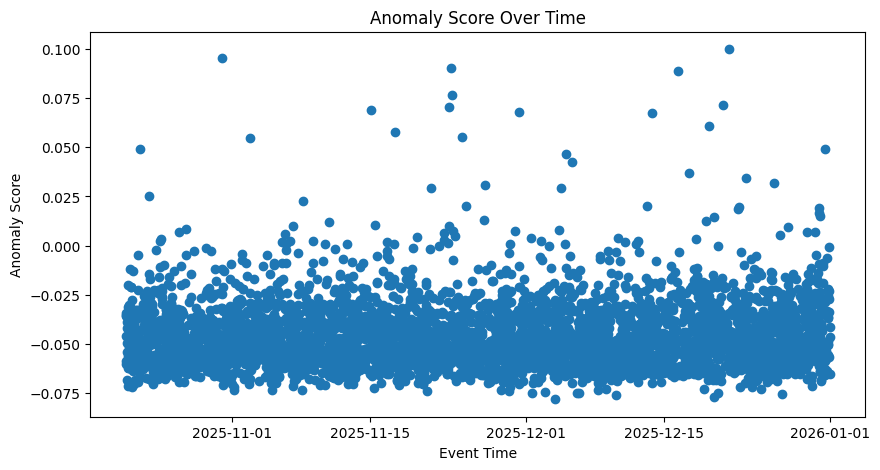

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(
    test_df["event_time"],
    test_df["anomaly_score"]
)
plt.xlabel("Event Time")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Score Over Time")
plt.show()
